## Setup environment

In [5]:
pwd

'/home/xzhang/Projects/cellpose'

In [27]:
import os
import json
import shutil
import tempfile
import time
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 0.10.dev2225
Numpy version: 1.22.3
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 6a2067a26b69aee6bcb4cf2b7adcda2c6e9adaed
MONAI __file__: /home/xzhang/anaconda3/envs/monai/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.0
gdown version: 4.4.0
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.4.2
einops version: 0.4.1
transformers version: 4.18.0
mlflow version: 1.26.1
pynrrd version: 0.4.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [9]:
import torch 
torch.device('cuda')

device(type='cuda')

In [9]:
# make UNet + WS prediction
# configuration to segment nanolive cell dataset
# make predictions and then save the result mask 
from natsort import natsorted
from monai import data, transforms
import tifffile


root_data_folder = '/home/xzhang/Projects/swincell/Nanolive_mem_cellpose_data_v5_nor_1_99'


for fold in range(1,6):
    # model_path = f'/home/xzhang/Projects/cellpose/runs/Nanolive_mem_cellpose_{model_type}_128_128_32_v6_nor_dsp{downsample_factor}_test_contrast_scratch_no_aug_5fold/fold{fold}/model_final.pt'
    # root_data_folder = '/data/nanolive/06222023_segmentation/'
    image_files = natsorted(glob.glob(root_data_folder + '/images/*.tiff'))
    seg_files = natsorted(glob.glob(root_data_folder + '/labels/*.tiff'))
    test_img_full_paths = [f for i,f in enumerate(image_files) if i%5 == (fold%5)]
    test_label_full_paths = [f for i,f in enumerate(seg_files) if i%5 == (fold%5)]

    print('test_img_full_paths',len(test_img_full_paths),test_img_full_paths,'\n')
    print('test_label_full_paths',len(test_label_full_paths),test_label_full_paths)
    break
    output_dir = root_data_folder + f'/results_3d_v5_{model_type}_monai_minsize_{round(min_size)}_fold{fold}' 





test_img_full_paths 2 ['/home/xzhang/Projects/swincell/Nanolive_mem_cellpose_data_v5_nor_1_99/images/3_RI_time00h00m00s.tiff', '/home/xzhang/Projects/swincell/Nanolive_mem_cellpose_data_v5_nor_1_99/images/31_RI_time00h00m00s.tiff'] 

test_label_full_paths 2 ['/home/xzhang/Projects/swincell/Nanolive_mem_cellpose_data_v5_nor_1_99/labels/3_RI_time00h00m00sws_mask_new_new.tiff', '/home/xzhang/Projects/swincell/Nanolive_mem_cellpose_data_v5_nor_1_99/labels/31_RI_time00h00m00s_pred_v2_new.tiff']


In [11]:
# test_datalist = [{'image':a} for a in img_full_paths[0::10]] 




## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

# compare model performance

In [32]:
# show results
from natsort import natsorted
import tifffile 
import glob
import numpy as np


# train_img_files = [f for i,f in enumerate(image_files) if i%5 != 0]
# train_seg_files = [f for i,f in enumerate(seg_files) if i%5 != 0]

fold =1 
seg_result_files_cellpose= natsorted(glob.glob(root_data_folder + f'/2d_cellpose_algo2/cellpose*.tif*'))

seg_result_files_swincell= natsorted(glob.glob(root_data_folder + f'/results_3d_v5_swinunetr_dsp1_monai_minsize_2500/cellpose*.tif*'))
raw_image_files = natsorted(glob.glob(root_data_folder+'/images/*tif*'))
gt_files = natsorted(glob.glob(root_data_folder+'/labels/*tif*'))
# print(root_data_folder)
print(len(seg_result_files_swincell),len(gt_files),len(seg_result_files_cellpose))
#segmentation only have 4 result images for now----------------------------------

# gt_files = [gt_files[i] for i in [0,1,5,6]]
# seg_result_files_swincell= [seg_result_files_swincell[i] for i in [0,1,5,6]]
# raw_image_files = [raw_image_files[i] for i in [0,1,5,6]]
# print(gt_files[0:2],gt_files[5:7])
# print(gt_files)
N_image = len(seg_result_files_swincell)

10 10 10


In [33]:
from stardist_matching import matching
import pandas as pd
N_thresholds =15
mAP_3d_list_swincell =np.zeros((N_image,N_thresholds))
mAP_3d_list_cellpose=np.zeros((N_image,N_thresholds))

output_compare_swincell_cellpose = pd.DataFrame()
# output_cellpose = pd.DataFrame()

for i in range(len(seg_result_files_swincell)):
    for idxt,threshold in enumerate(np.linspace(0.5,1,N_thresholds)):
        gt_img = tifffile.imread(gt_files[i])
        # if downsample_factor>1:
        #     # gt_img = gt_img[1:-1:downsample_factor,1:-1:downsample_factor,1:-1:downsample_factor]
        #     gt_img = gt_img[0:-2:downsample_factor,0:-2:downsample_factor,0:-2:downsample_factor]
        # results 3d
        img_3d = tifffile.imread(seg_result_files_swincell[i])
        mAP_3d = matching(gt_img,img_3d,  thresh=threshold)
        
        df_temp = pd.DataFrame([mAP_3d])
        df_temp['img_id'] = str(gt_files[i].split('/')[-1])
        df_temp['method'] = 'swincell'
        output_compare_swincell_cellpose = pd.concat([output_compare_swincell_cellpose,df_temp])

for i in range(len(seg_result_files_cellpose)):
    for idxt,threshold in enumerate(np.linspace(0.5,1,N_thresholds)):
        gt_img = tifffile.imread(gt_files[i])
        # if downsample_factor>1:
        #     # gt_img = gt_img[1:-1:downsample_factor,1:-1:downsample_factor,1:-1:downsample_factor]
        #     gt_img = gt_img[0:-2:downsample_factor,0:-2:downsample_factor,0:-2:downsample_factor]
        # results 3d
        img_3d = tifffile.imread(seg_result_files_cellpose[i])
        mAP_3d = matching(gt_img,img_3d,  thresh=threshold)
        
        df_temp = pd.DataFrame([mAP_3d])
        df_temp['img_id'] = str(gt_files[i].split('/')[-1])
        df_temp['method'] = 'cellpose'
        output_compare_swincell_cellpose = pd.concat([output_compare_swincell_cellpose,df_temp])
        
print(output_compare_swincell_cellpose.head(20))



Empty DataFrame
Columns: []
Index: []


In [34]:
#save output to csv ??
# output_compare_swincell_cellpose.to_csv('output_compare_swincell_cellpose.csv')
# output_swinunetr.to_csv('output_swinunetr.csv')
# load output from csv
# import pandas as pd
if 1: # load precomputed results?
    # output_unet = pd.read_csv('output_unet.csv')
    # output_swinunetr = pd.read_csv('output_swinunetr.csv')
    output_compare_swincell_cellpose= pd.read_csv('output_compare_swincell_cellpose_nooutlier.csv')
    seg_result_files_swinunetr = [1]*9
    seg_result_files_unet = [1]*9
    # N_thresholds = 15
    N_image = 9

print(output_compare_swincell_cellpose.shape)

(300, 17)


In [44]:
output_3d_swincell= output_compare_swincell_cellpose[output_compare_swincell_cellpose['method']=='swincell']
output_cellpose= output_compare_swincell_cellpose[output_compare_swincell_cellpose['method']=='cellpose']
a= output_3d_swincell['precision'].values.shape
mAP_3d_list_swincell =output_3d_swincell['precision'].values.reshape(N_image,N_thresholds)
f1_3d_list_swincell =output_3d_swincell['f1'].values.reshape(N_image,N_thresholds)
fp_3d_list_swincell =output_3d_swincell['fp'].values.reshape(N_image,N_thresholds)
tp_3d_list_swincell =output_3d_swincell['tp'].values.reshape(N_image,N_thresholds)
fn_3d_list_swincell =output_3d_swincell['fn'].values.reshape(N_image,N_thresholds)

recall_3d_list_swincell =output_3d_swincell['recall'].values.reshape(N_image,N_thresholds)
accuracy_3d_list_swincell =output_3d_swincell['accuracy'].values.reshape(N_image,N_thresholds)


mAP_3d_list_cellpose =output_cellpose['precision'].values.reshape(N_image,N_thresholds)
f1_3d_list_cellpose =output_cellpose['f1'].values.reshape(N_image,N_thresholds)
fp_3d_list_cellpose =output_cellpose['fp'].values.reshape(N_image,N_thresholds)
tp_3d_list_cellpose =output_cellpose['tp'].values.reshape(N_image,N_thresholds)
fn_3d_list_cellpose =output_cellpose['fn'].values.reshape(N_image,N_thresholds)

recall_3d_list_cellpose =output_cellpose['recall'].values.reshape(N_image,N_thresholds)
accuracy_3d_list_cellpose =output_cellpose['accuracy'].values.reshape(N_image,N_thresholds)
# from matplotlib import pyplot as plt
# fig,ax = plt.subplots(1,2,figsize=(12,4), dpi=300)
# idx =1
# ax[0].plot(np.linspace(0.5,1,N_thresholds),mAP_3d_list[idx],linewidth=2,label='3D cellpose') 
# ax[0].legend(loc='lower left',frameon=False,fontsize=12)
# # ax[0].legend()
# # change font size in the figure
# ax[0].set_xlabel('IoU Threshold',fontsize=12)
# ax[0].set_ylabel('mAP',fontsize=12)
print('swincell averaged F1 score at 0.5 is: ', f1_3d_list_swincell[:,0].mean())


print('swincell averaged mAP score at 0.5 is: ', mAP_3d_list_swincell[:,0].mean())
print('swincell averaged recall score at 0.5 is: ', recall_3d_list_swincell[:,0].mean())
print('---------------------------------')

# print('cellpose F1 score std at 0.5 is: ', f1_3d_list_cellpose[:,0].std())

print('cellpose averaged F1 score at 0.5 is: ', f1_3d_list_cellpose[:,0].mean())
print('cellpose averaged mAP score at 0.5 is: ', mAP_3d_list_cellpose[:,0].mean())
print('cellpose averaged recall score at 0.5 is: ', recall_3d_list_cellpose[:,0].mean())



swincell averaged F1 score at 0.5 is:  0.8561649389438329
swincell averaged mAP score at 0.5 is:  0.8351054066454038
swincell averaged recall score at 0.5 is:  0.8838451655130398
---------------------------------
cellpose averaged F1 score at 0.5 is:  0.4298297861373752
cellpose averaged mAP score at 0.5 is:  0.29666893972243735
cellpose averaged recall score at 0.5 is:  0.807282927978388


In [22]:
print(f1_3d_list_cellpose)

[[1.         1.         1.         1.         0.        ]
 [0.66666667 0.51851852 0.2962963  0.11111111 0.        ]
 [1.         1.         1.         0.88888889 0.        ]
 [0.71111111 0.66666667 0.44444444 0.04444444 0.        ]]


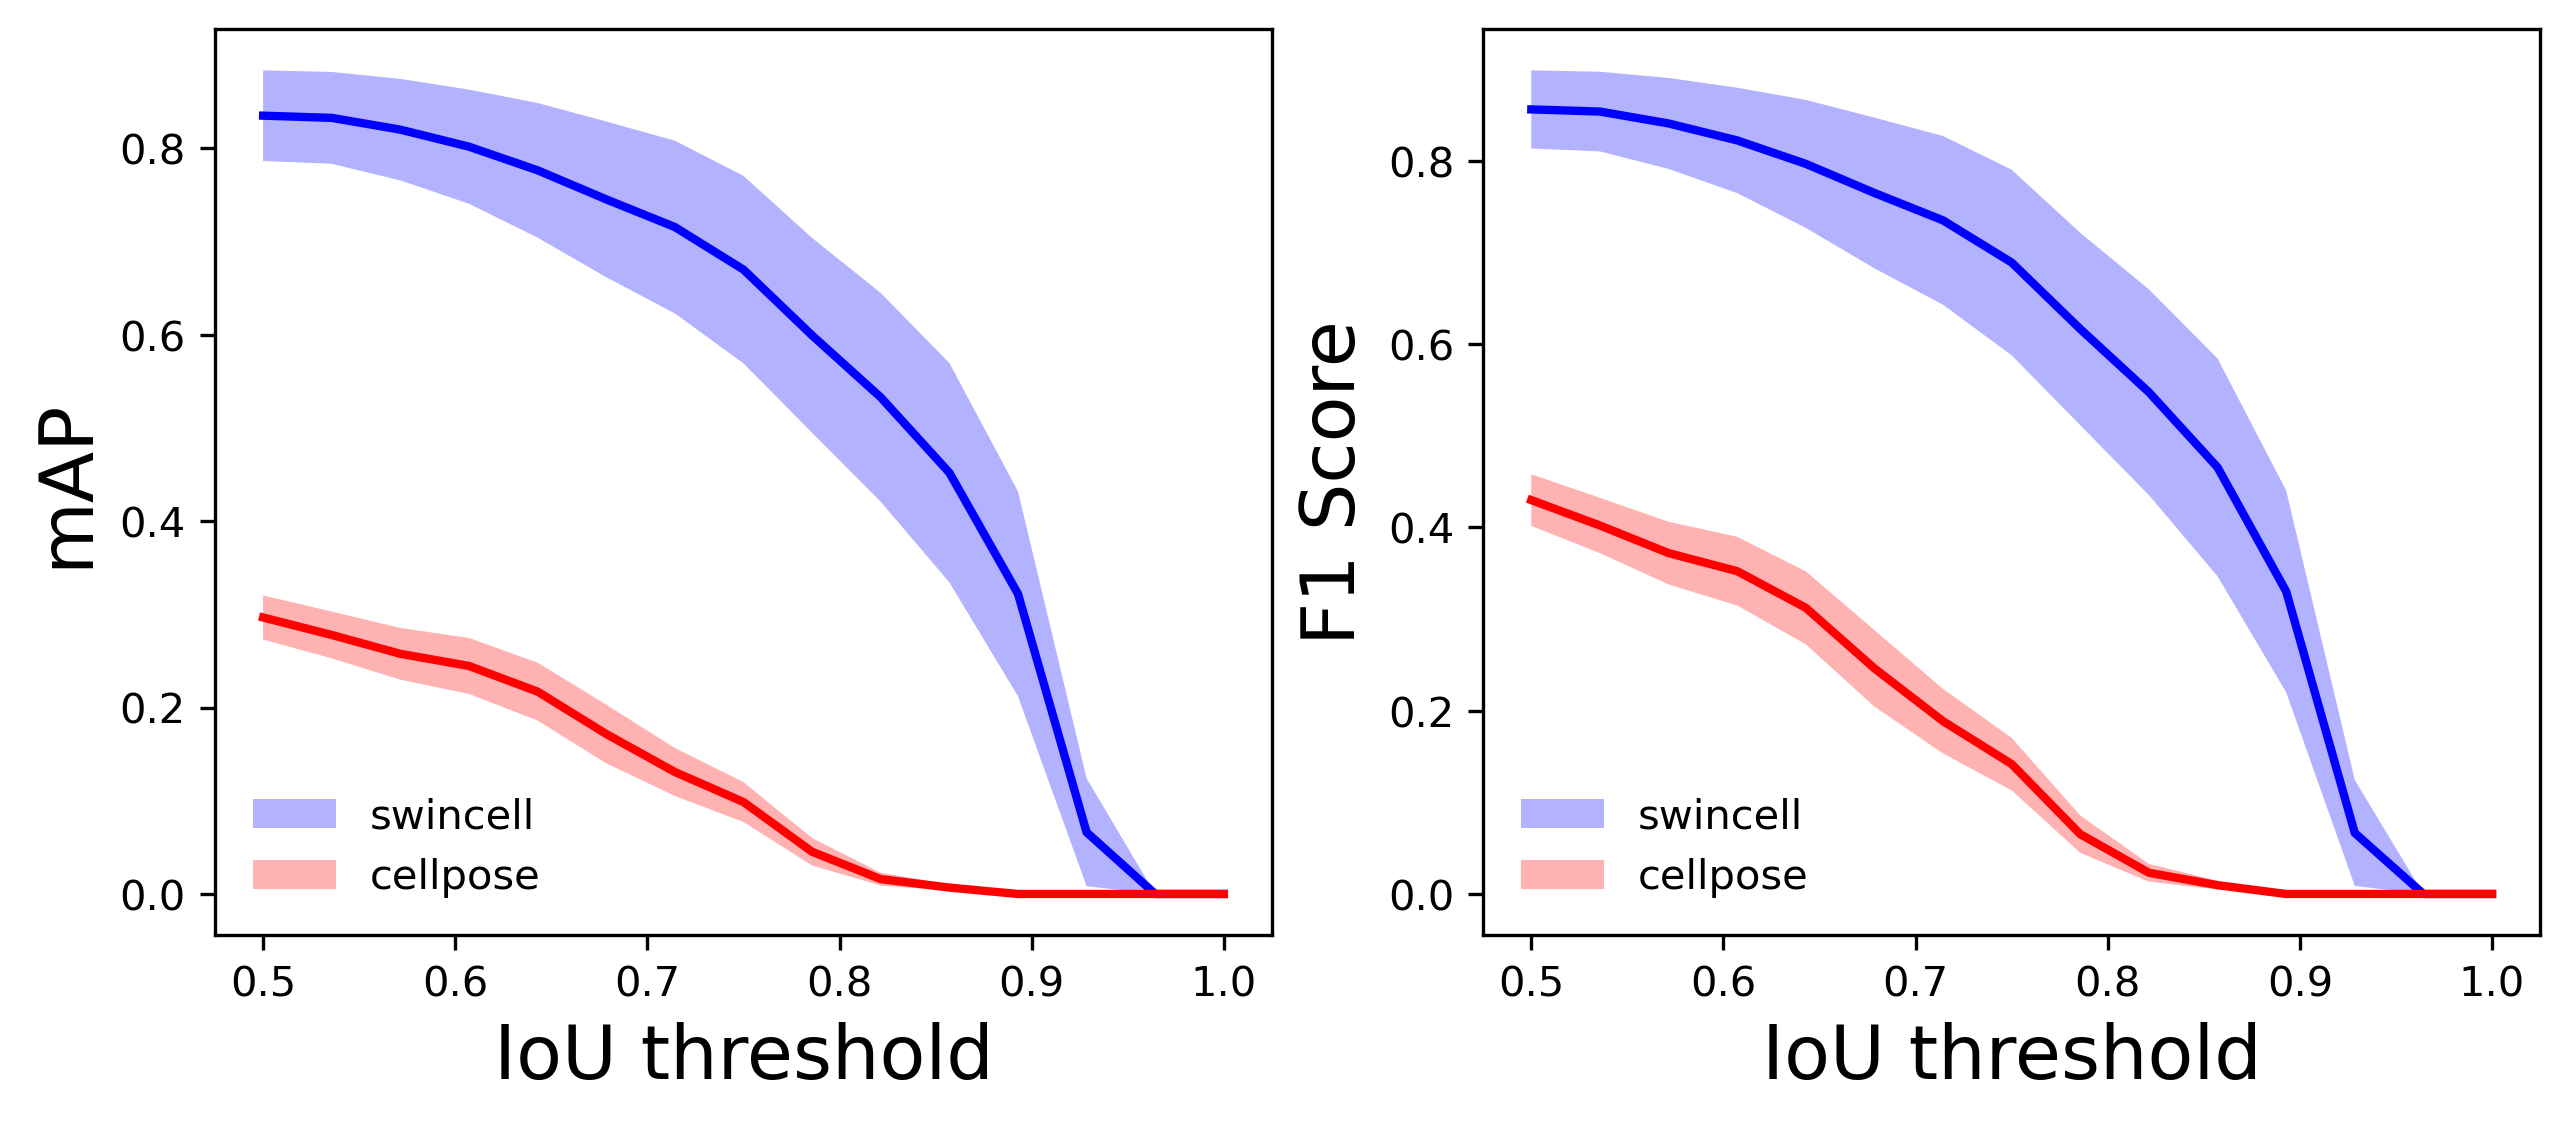

In [202]:
from matplotlib import pyplot as plt
from utils.utils import plot_with_se
# def plot_with_se(ax,matrix,label=None,style='-',color=None):
#     mean = np.mean(matrix, axis=0)
#     std = np.std(matrix, axis=0)
#     se = std / np.sqrt(matrix.shape[0])
#     ax.plot(iou_thresholds,mean,linewidth=2,linestyle=style,color=color)

#     ax.fill_between(iou_thresholds,mean-se,mean+se,alpha=0.3,label=label,color=color,edgecolor=None)
#     return ax
# N_thresholds =5
iou_thresholds = np.linspace(0.5,1,N_thresholds)
fig,ax = plt.subplots(1,2,figsize=(10,4), dpi=300)
plot_with_se(ax[0],mAP_3d_list_swincell,iou_thresholds,label='swincell',color='blue')
plot_with_se(ax[0],mAP_3d_list_cellpose,iou_thresholds,label='cellpose',color='red')
ax[0].set_ylabel('mAP',fontsize =18)
ax[0].set_xlabel('IoU threshold',fontsize =18)
ax[0].legend(loc='lower left',frameon=False,fontsize=10) 

plot_with_se(ax[1],f1_3d_list_swincell,iou_thresholds,label='swincell',color='blue')
plot_with_se(ax[1],f1_3d_list_cellpose,iou_thresholds,label='cellpose',color='red')
ax[1].set_ylabel('F1 Score',fontsize =18)
ax[1].set_xlabel('IoU threshold',fontsize =18)
ax[1].legend(loc='lower left',frameon=False,fontsize=10)

NameError: name 'plot_with_se' is not defined

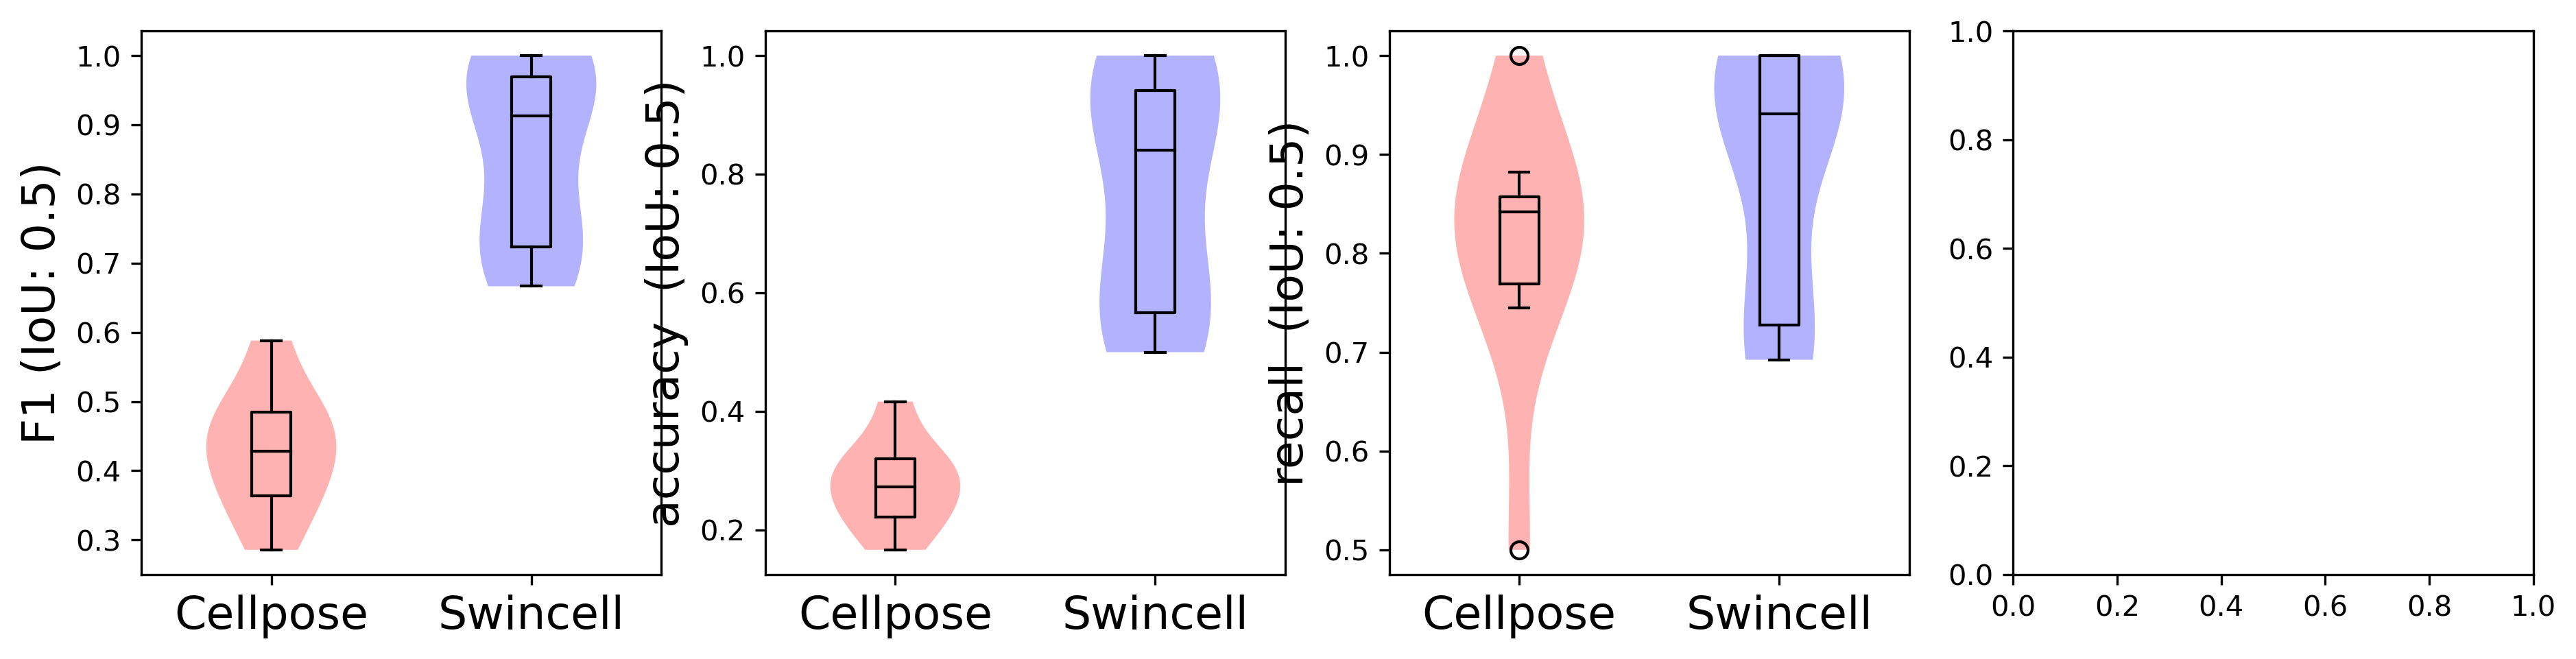

In [46]:

from utils.utils import plot_box_with_violin
threshold_idx = 0 #  0 for 0.5, 1 for 0.6, 2 for 0.7, 3 for 0.8
f1_3d_list_05= [f1_3d_list_cellpose[:,threshold_idx],f1_3d_list_swincell[:,threshold_idx]]  #first column is threshold=0.5
# fp_3d_list_05= [fp_3d_list_unet[:,0],fp_3d_list_swinunetr[:,0]] 
fp_3d_list_05= [fp_3d_list_cellpose[:,threshold_idx],fp_3d_list_swincell[:,threshold_idx]]
tp_3d_list_05= [tp_3d_list_cellpose[:,threshold_idx],tp_3d_list_swincell[:,threshold_idx]]
fn_3d_list_05= [fn_3d_list_cellpose[:,threshold_idx],fn_3d_list_swincell[:,threshold_idx]]

recall_3d_list_05= [recall_3d_list_cellpose[:,threshold_idx],recall_3d_list_swincell[:,threshold_idx]]
accuracy_3d_list_05= [accuracy_3d_list_cellpose[:,threshold_idx],accuracy_3d_list_swincell[:,threshold_idx]]


fig,ax = plt.subplots(1,4,figsize=(15,3.5), dpi=300)
ax[0] = plot_box_with_violin(ax[0],f1_3d_list_05,facecolorlist=['red','blue'])
ax[0].set_xticklabels(['Cellpose', 'Swincell'],fontsize =16)
ax[0].set_ylabel('F1 (IoU: 0.5)',fontsize =16)

# ax[0][1] = plot_box_with_violin(ax[0][1],fp_3d_list_05,facecolor='red')
# ax[0][1].set_xticklabels(['Unet', 'SwinUnetr'],fontsize =16)
# ax[0][1].set_ylabel('fp',fontsize =16)
ax[1] = plot_box_with_violin(ax[1],accuracy_3d_list_05,facecolorlist=['red','blue'])
ax[1].set_xticklabels(['Cellpose', 'Swincell'],fontsize =16)
ax[1].set_ylabel('accuracy  (IoU: 0.5)',fontsize =16)

ax[2] = plot_box_with_violin(ax[2],recall_3d_list_05,facecolorlist=['red','blue'])
ax[2].set_xticklabels(['Cellpose', 'Swincell'],fontsize =16)
ax[2].set_ylabel('recall  (IoU: 0.5)',fontsize =16)

if 0:    # show number of false positives
    ax[3] = plot_box_with_violin(ax[3],fp_3d_list_05,facecolorlist=['red','blue'])
    ax[3].set_xticklabels(['Cellpose', 'Swincell'],fontsize =16)
    ax[3].set_ylabel('False Positive',fontsize =16)
else:
    plot_with_se(ax[3],mAP_3d_list_swincell,iou_thresholds,label='swincell',color='blue')
    plot_with_se(ax[3],mAP_3d_list_cellpose,iou_thresholds,label='cellpose',color='red')
    ax[3].set_ylabel('mAP',fontsize =16)
    ax[3].set_xlabel('IoU threshold',fontsize =16)
    ax[3].legend(loc='lower left',frameon=False,fontsize=10) 

plt.tight_layout()

10 10 10 10
(96, 512, 512) (96, 512, 512) (96, 512, 512) (96, 512, 512)


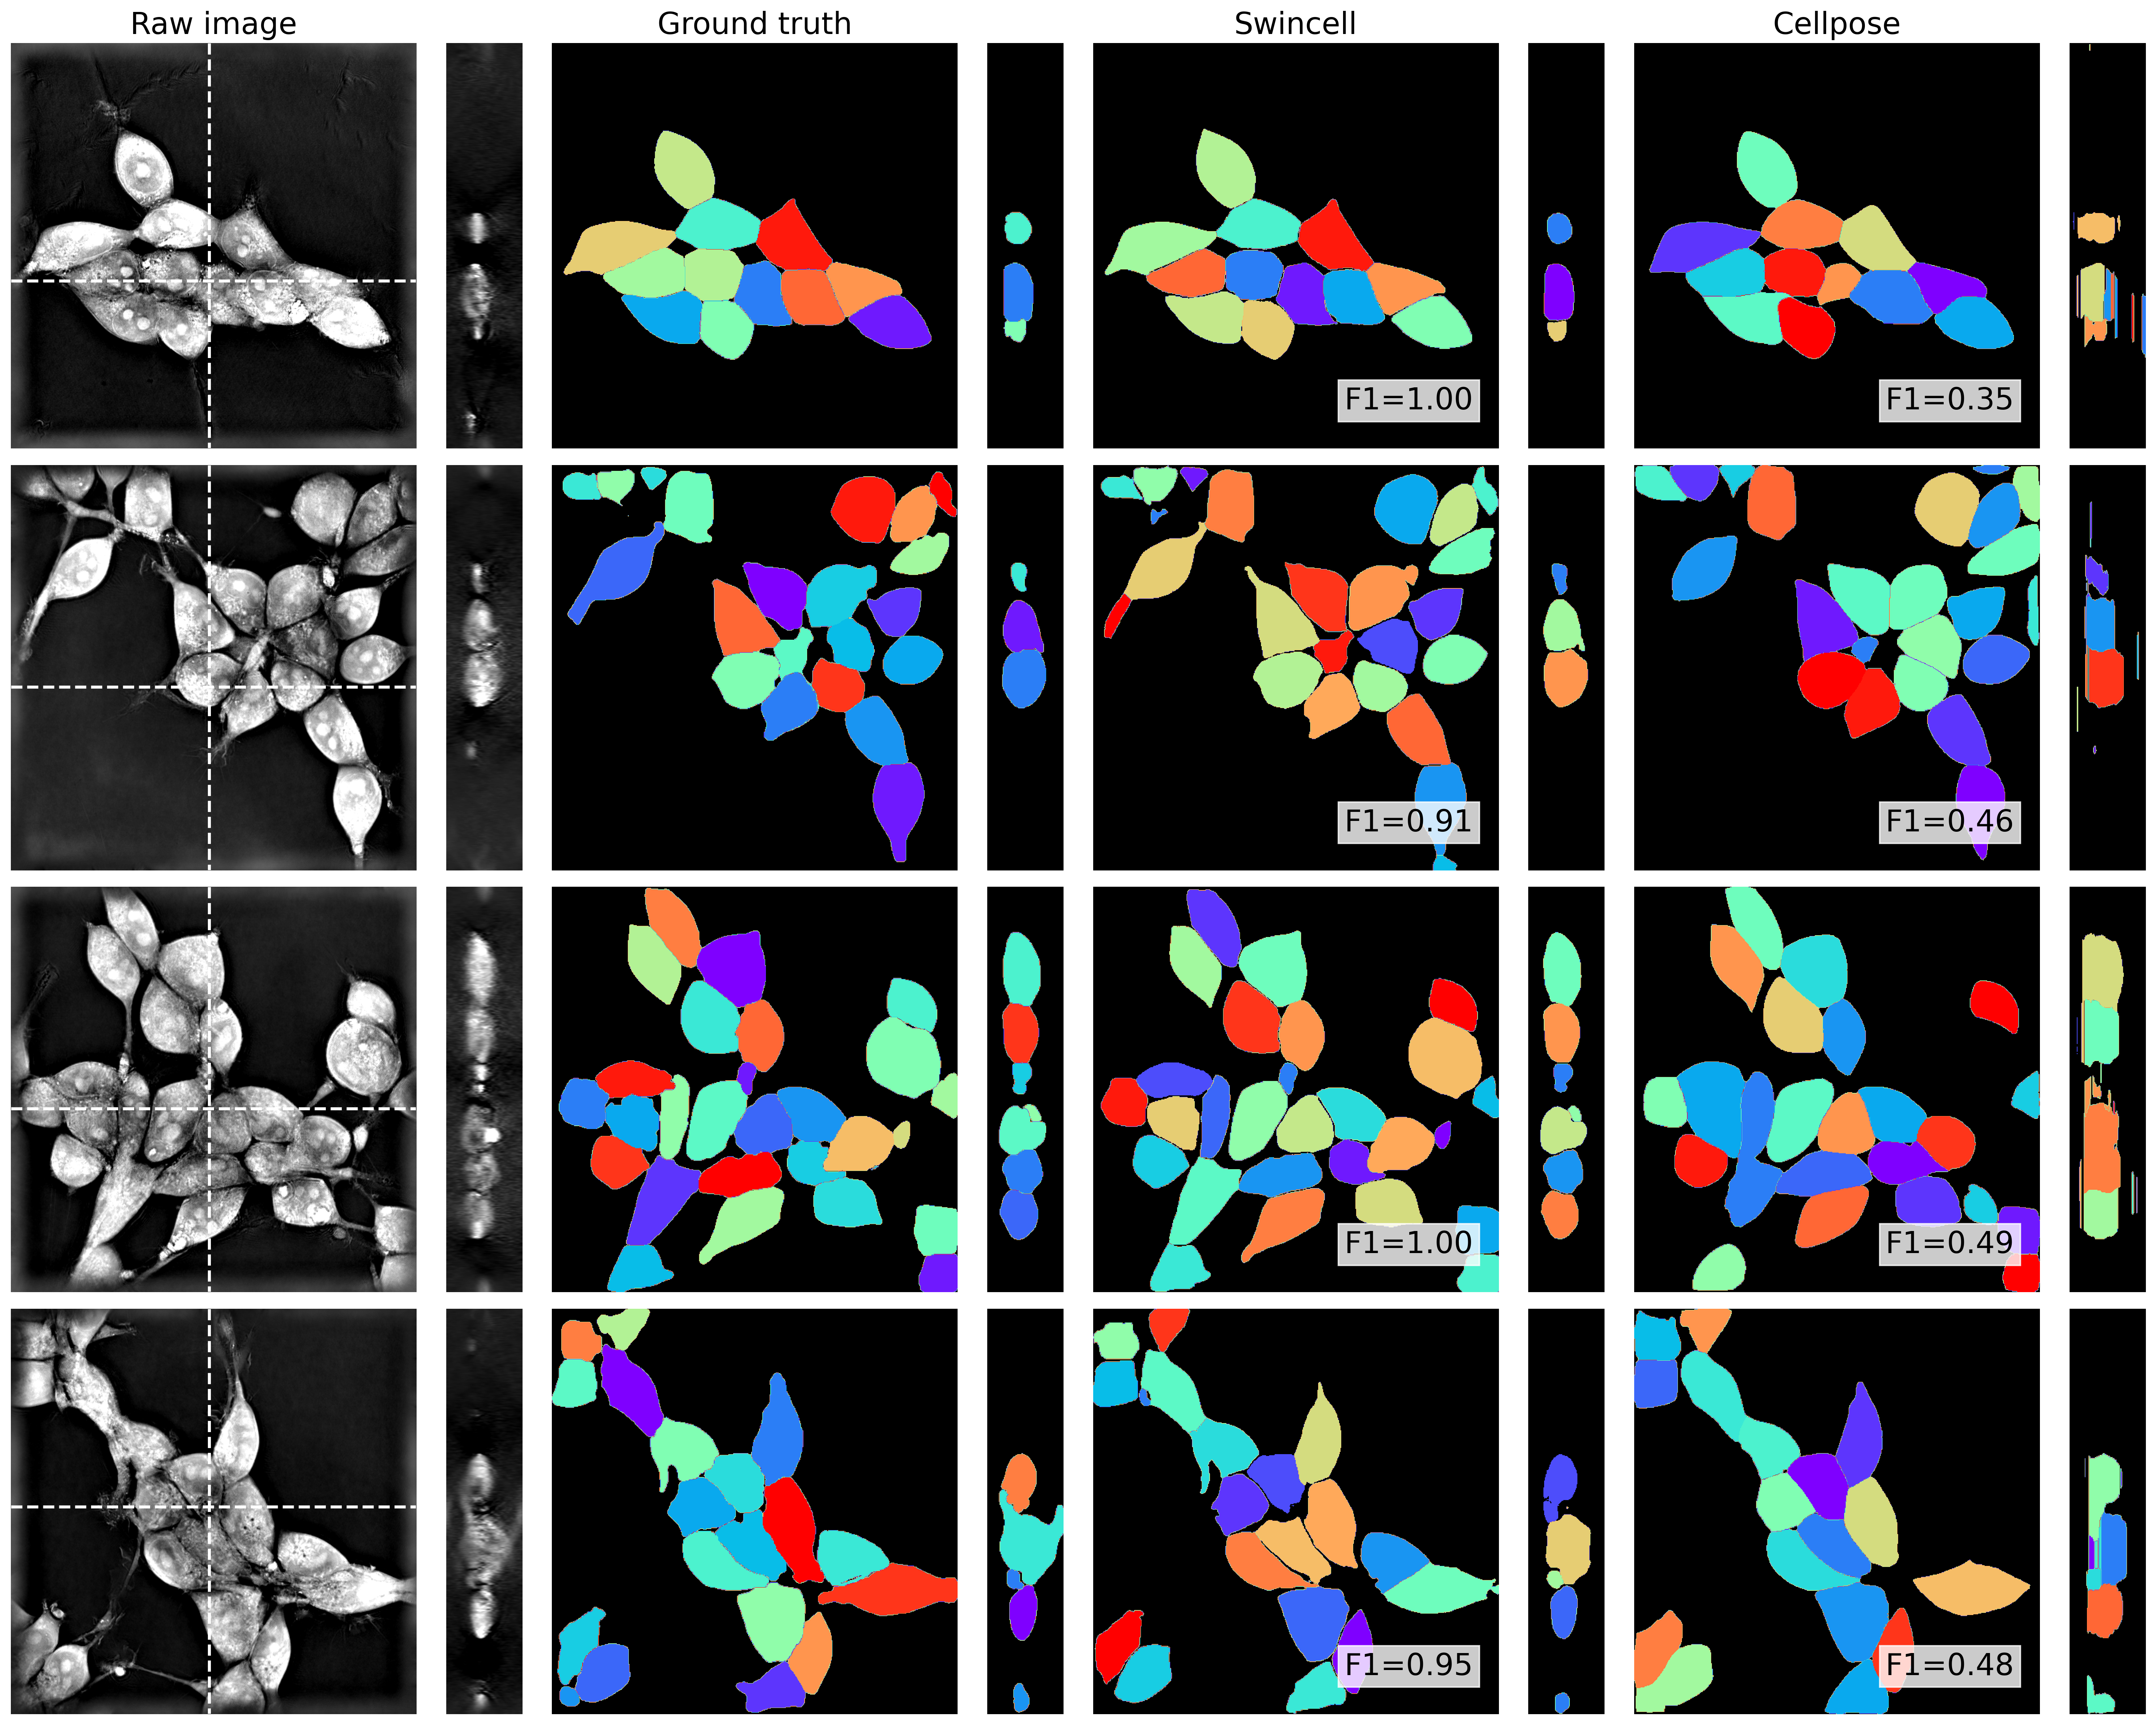

In [47]:
# show swinunetr result only 
from cv2_utils import get_random_cmap
from natsort import natsorted
import numpy as np
import glob
import tifffile
from matplotlib import pyplot as plt
from stardist_matching import matching
import scipy.ndimage as ndimage
# update configuration, not needed if run code from beginning
fontsize= 20
downsample_factor = 1
matching_threshold = 0.5

def load_files(file_idx):
      img_raw = tifffile.imread(raw_image_files[file_idx])
      img_gt = tifffile.imread(gt_files[file_idx])
      img_seg_swincell = tifffile.imread(seg_result_files_swincell[file_idx])
      img_seg_cellpose = tifffile.imread(seg_result_files_cellpose[file_idx])
      return img_raw, img_gt, img_seg_swincell, img_seg_cellpose

# root_folder = '/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_v5_nor_1_99'
# image_files = natsorted(glob.glob(root_folder + '/images/*.tif*'))
# gt_files = natsorted(glob.glob(root_folder + '/labels/*.tiff'))
# seg_files = natsorted(glob.glob(root_folder + f'/results_3d_v5_{model_type}_dsp{downsample_factor}_monai_minsize_{round(min_size)}/*.tiff'))

print(len(raw_image_files),len(gt_files), len(seg_result_files_cellpose),len(seg_result_files_swincell) )



# if downsample_factor>1:
#       img_gt = img_gt[:-2:downsample_factor,:-2:downsample_factor,:-2:downsample_factor]
#       # img_seg = img_seg[:-2:downsample_factor,:-2:downsample_factor,:-2:downsample_factor]


img_raw, img_gt, img_seg_swincell, img_seg_cellpose = load_files(0)
textx = img_raw.shape[2]-135 -60
texty = img_raw.shape[1]-50 

print(img_raw.shape,img_seg_swincell.shape,img_seg_cellpose.shape,img_gt.shape)

#----------------row 1---------------
# slice_xy1 = 50//downsample_factor-12
slice_xy1 = 50//downsample_factor-8 #slice selected from imageJ
slice_yz1 = 250//downsample_factor

slice_xy2 = 50//downsample_factor-12
slice_yz2 = 250//downsample_factor

slice_xy3 = 50//downsample_factor-12
slice_yz3 = 250//downsample_factor

slice_xy4 = 50//downsample_factor-12
slice_yz4 = 250//downsample_factor

slice_xz1 = 300//downsample_factor
slice_xz2 = 280//downsample_factor
slice_xz3 = 280//downsample_factor
slice_xz4 = 250//downsample_factor

width_ratio = 0.2
fig,ax = plt.subplots(4,8,figsize=(20,16), dpi=300,gridspec_kw={'width_ratios': \
                                    [1, width_ratio,1, width_ratio,1, width_ratio,1, width_ratio],'height_ratios': [1, 1,1,1]})
cell_num =30

swincell_f1 =matching(img_gt, img_seg_swincell, thresh=matching_threshold).f1
cellpose_f1 =matching(img_gt, img_seg_cellpose, thresh=matching_threshold).f1

ax[0,0].imshow(img_raw[slice_xy1],cmap='gray')
ax[0,0].plot([0,511],[slice_xz1,slice_xz1],linewidth=2,linestyle='--',color='white')
ax[0,0].plot([slice_yz1,slice_yz1],[0,511],linewidth=2,linestyle='--',color='white')
ax[0,0].set_title('Raw image',fontsize=fontsize)

ax[0,2].imshow(img_gt[slice_xy1],cmap= get_random_cmap(cell_num,background=0))
ax[0,2].set_title('Ground truth',fontsize=fontsize)

ax[0,6].imshow(img_seg_cellpose[slice_xy1],cmap= get_random_cmap(cell_num,background=0))
ax[0,6].set_title('Cellpose',fontsize=fontsize)
ax[0,6].text(textx, texty, 'F1={:0.2f}'.format(cellpose_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)

ax[0,4].imshow(img_seg_swincell[slice_xy1],cmap= get_random_cmap(cell_num,background=0))
ax[0,4].set_title('Swincell',fontsize=fontsize)
ax[0,4].text(textx, texty, 'F1={:0.2f}'.format(swincell_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)

ax[0,1].imshow(img_raw[:,:,slice_yz1].T,cmap='gray')
# ax[1,0].set_title('Raw image')

ax[0,3].imshow(img_gt[:,:,slice_yz1].T,cmap= get_random_cmap(cell_num,background=0))
# ax[1,1].set_title('Ground truth')

ax[0,7].imshow(img_seg_cellpose[:,:,slice_yz1].T,cmap= get_random_cmap(cell_num,background=0))
# # ax[1,2].set_title('Cellpose')
# ax[2,5].text(textx, texty, 'F1={:0.2f}'.format(cellpose_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)
ax[0,5].imshow(img_seg_swincell[:,:,slice_yz1].T,cmap= get_random_cmap(cell_num,background=0))
#------------------row 2-------------



img_raw, img_gt, img_seg_swincell, img_seg_cellpose = load_files(2)

swincell_f1 =matching(img_gt, img_seg_swincell, thresh=matching_threshold).f1
cellpose_f1 =matching(img_gt, img_seg_cellpose, thresh=matching_threshold).f1

ax[1,0].imshow(img_raw[slice_xy2],cmap='gray')
ax[1,0].plot([0,511],[slice_xz2,slice_xz2],linewidth=2,linestyle='--',color='white')
ax[1,0].plot([slice_yz2,slice_yz2],[0,511],linewidth=2,linestyle='--',color='white')
# ax[1,0].set_title('Raw image')

ax[1,2].imshow(img_gt[slice_xy2],cmap= get_random_cmap(cell_num,background=0))
# ax[1,1].set_title('Ground truth')

ax[1,6].imshow(img_seg_cellpose[slice_xy2],cmap= get_random_cmap(cell_num,background=0))
# ax[1,2].set_title('Cellpose')
ax[1,6].text(textx, texty, 'F1={:0.2f}'.format(cellpose_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)

ax[1,4].imshow(img_seg_swincell[slice_xy2],cmap= get_random_cmap(cell_num,background=0))
# ax[1,3].set_title('Swincell')
ax[1,4].text(textx, texty, 'F1={:0.2f}'.format(swincell_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)


ax[1,1].imshow(img_raw[:,:,slice_yz2].T,cmap='gray')

ax[1,3].imshow(img_gt[:,:,slice_yz2].T,cmap= get_random_cmap(cell_num,background=0))

ax[1,7].imshow(img_seg_cellpose[:,:,slice_yz2].T,cmap= get_random_cmap(cell_num,background=0))

ax[1,5].imshow(img_seg_swincell[:,:,slice_yz2].T,cmap= get_random_cmap(cell_num,background=0))
#----------------row 3---------------

img_raw, img_gt, img_seg_swincell, img_seg_cellpose = load_files(5)


cell_num =30

swincell_f1 =matching(img_gt, img_seg_swincell, thresh=matching_threshold).f1
cellpose_f1 =matching(img_gt, img_seg_cellpose, thresh=matching_threshold).f1

ax[2,0].imshow(img_raw[slice_xy3],cmap='gray')

ax[2,0].plot([0,511],[slice_xz3,slice_xz3],linewidth=2,linestyle='--',color='white')
ax[2,0].plot([slice_yz3,slice_yz3],[0,511],linewidth=2,linestyle='--',color='white')
# ax[2,0].set_title('Raw image',fontsize=fontsize)

ax[2,2].imshow(img_gt[slice_xy3],cmap= get_random_cmap(cell_num,background=0))
# ax[2,2].set_title('Ground truth',fontsize=fontsize)

ax[2,6].imshow(img_seg_cellpose[slice_xy3],cmap= get_random_cmap(cell_num,background=0))
# ax[2,4].set_title('Cellpose',fontsize=fontsize)
ax[2,6].text(textx, texty, 'F1={:0.2f}'.format(cellpose_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)

ax[2,4].imshow(img_seg_swincell[slice_xy3],cmap= get_random_cmap(cell_num,background=0))
# ax[2,6].set_title('Swincell',fontsize=fontsize)
ax[2,4].text(textx, texty, 'F1={:0.2f}'.format(swincell_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)


ax[2,1].imshow(img_raw[:,:,slice_yz3].T,cmap='gray')
# ax[1,0].set_title('Raw image')

ax[2,3].imshow(img_gt[:,:,slice_yz3].T,cmap= get_random_cmap(cell_num,background=0))
# ax[1,1].set_title('Ground truth')

ax[2,7].imshow(img_seg_cellpose[:,:,slice_yz3].T,cmap= get_random_cmap(cell_num,background=0))
# # ax[1,2].set_title('Cellpose')
# ax[2,5].text(textx, texty, 'F1={:0.2f}'.format(cellpose_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)
ax[2,5].imshow(img_seg_swincell[:,:,slice_yz3].T,cmap= get_random_cmap(cell_num,background=0))
#----------------row 4---------------

img_raw, img_gt, img_seg_swincell, img_seg_cellpose = load_files(8)

swincell_f1 =matching(img_gt, img_seg_swincell, thresh=matching_threshold).f1
cellpose_f1 =matching(img_gt, img_seg_cellpose, thresh=matching_threshold).f1

ax[3,0].imshow(img_raw[slice_xy4],cmap='gray')
# ax[3,0].set_title('Raw image',fontsize=fontsize)
ax[3,0].plot([0,511],[slice_xz4,slice_xz4],linewidth=2,linestyle='--',color='white')
ax[3,0].plot([slice_yz4,slice_yz4],[0,511],linewidth=2,linestyle='--',color='white')

ax[3,2].imshow(img_gt[slice_xy4],cmap= get_random_cmap(cell_num,background=0))
# ax[3,2].set_title('Ground truth',fontsize=fontsize)

ax[3,6].imshow(img_seg_cellpose[slice_xy4],cmap= get_random_cmap(cell_num,background=0))
# ax[3,4].set_title('Cellpose',fontsize=fontsize)
ax[3,6].text(textx, texty, 'F1={:0.2f}'.format(cellpose_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)

ax[3,4].imshow(img_seg_swincell[slice_xy4],cmap= get_random_cmap(cell_num,background=0))
# ax[3,6].set_title('Swincell',fontsize=fontsize)
ax[3,4].text(textx, texty, 'F1={:0.2f}'.format(swincell_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)

ax[3,1].imshow(img_raw[:,:,slice_yz4].T,cmap='gray')
# ax[1,0].set_title('Raw image')

ax[3,3].imshow(img_gt[:,:,slice_yz4].T,cmap= get_random_cmap(cell_num,background=0))
# ax[1,1].set_title('Ground truth')

ax[3,7].imshow(img_seg_cellpose[:,:,slice_yz4].T,cmap= get_random_cmap(cell_num,background=0))
# # ax[1,2].set_title('Cellpose')
# ax[2,5].text(textx, texty, 'F1={:0.2f}'.format(cellpose_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)
ax[3,5].imshow(img_seg_swincell[:,:,slice_yz4].T,cmap= get_random_cmap(cell_num,background=0))




for i in range(4):
      for j in range(8):
            ax[i,j].axis('off')
plt.tight_layout()


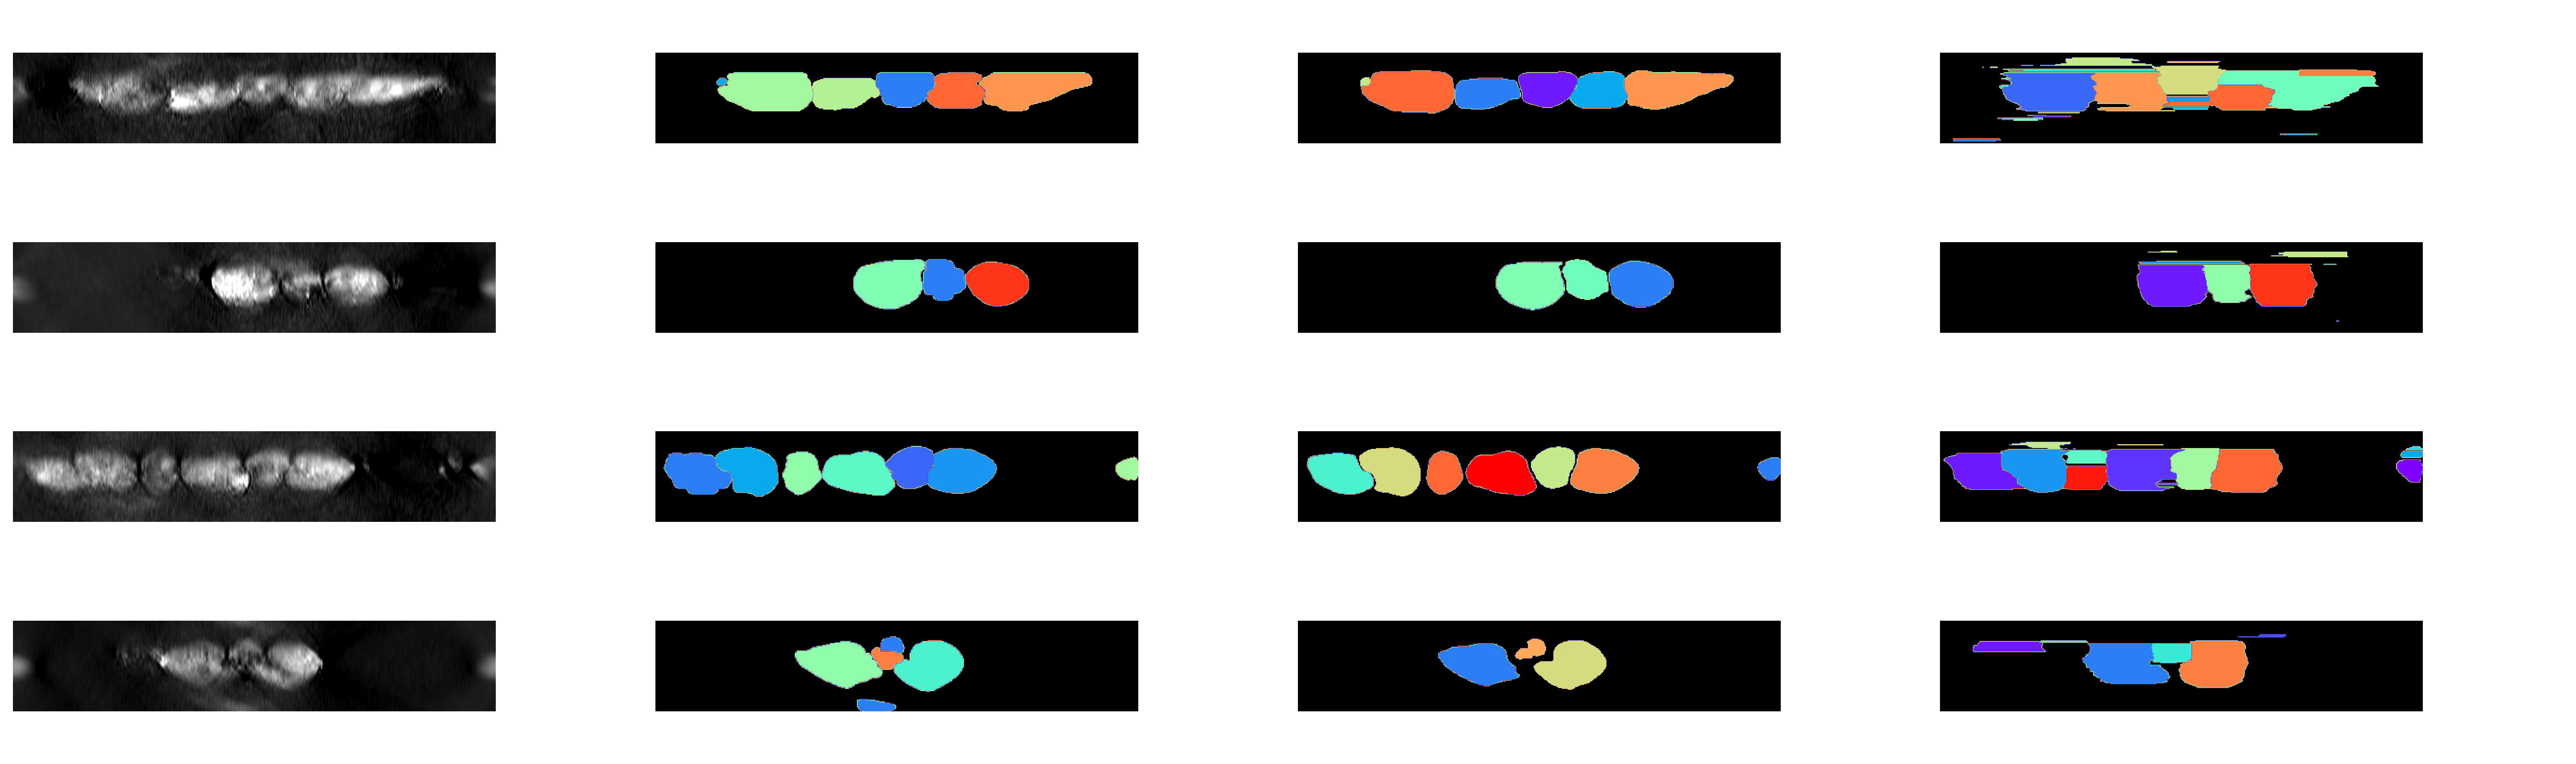

In [48]:
# def plot_sample_figure(slice_xy,slice_yz,file_idx,figure_row,ax):
#     img_raw = tifffile.imread(raw_image_files[file_idx])
#     img_gt = tifffile.imread(gt_files[file_idx])
#     # img_gt = measure.label(img_gt,background=0)
#     img_seg_swincell = tifffile.imread(seg_result_files_swincell[file_idx])
#     img_seg_cellpose = tifffile.imread(seg_result_files_cellpose[file_idx])

#     ax[figure_row,0].imshow(img_raw[slice_xy],cmap='gray')
#     ax[figure_row,2].imshow(img_gt[slice_xy],cmap= get_random_cmap(cell_num))
#     ax[figure_row,4].imshow(img_seg_cellpose[slice_xy],cmap= get_random_cmap(cell_num))
#     ax[figure_row,6].imshow(img_seg_swincell[slice_xy],cmap= get_random_cmap(cell_num))

#     ax[figure_row,1].imshow(img_raw[:,:,slice_yz].T,cmap='gray')
#     ax[figure_row,3].imshow(img_gt[:,:,slice_yz].T,cmap= get_random_cmap(cell_num))
#     ax[figure_row,5].imshow(img_seg_cellpose[:,:,slice_yz].T,cmap= get_random_cmap(cell_num))
#     ax[figure_row,7].imshow(img_seg_swincell[:,:,slice_yz].T,cmap= get_random_cmap(cell_num))


# slice_xy4 = 50//downsample_factor-12
# slice2 = 450//downsample_factor
# slice_yz4 = 250//downsample_factor
width_ratio = 0.25
fig,ax = plt.subplots(4,8,figsize=(20,6), dpi=300,gridspec_kw={'width_ratios': \
                                    [1, width_ratio,1, width_ratio,1, width_ratio,1, width_ratio],'height_ratios': [1, 1,1,1]})




img_raw, img_gt, img_seg_swincell, img_seg_cellpose = load_files(0)
ax[0,0].imshow(img_raw[:,slice_xz1],cmap='gray')
# ax[1,0].set_title('Raw image')
ax[0,2].imshow(img_gt[:,slice_xz1],cmap= get_random_cmap(cell_num,background=0))
# ax[1,1].set_title('Ground truth')
ax[0,6].imshow(img_seg_cellpose[:,slice_xz1],cmap= get_random_cmap(cell_num,background=0))
ax[0,4].imshow(img_seg_swincell[:,slice_xz1],cmap= get_random_cmap(cell_num,background=0))

img_raw, img_gt, img_seg_swincell, img_seg_cellpose = load_files(2)
ax[1,0].imshow(img_raw[:,slice_xz2],cmap='gray')
# ax[1,0].set_title('Raw image')
ax[1,2].imshow(img_gt[:,slice_xz2],cmap= get_random_cmap(cell_num,background=0))
ax[1,6].imshow(img_seg_cellpose[:,slice_xz2],cmap= get_random_cmap(cell_num,background=0))
ax[1,4].imshow(img_seg_swincell[:,slice_xz2],cmap= get_random_cmap(cell_num,background=0))

img_raw, img_gt, img_seg_swincell, img_seg_cellpose = load_files(5)
ax[2,0].imshow(img_raw[:,slice_xz3],cmap='gray')
ax[2,2].imshow(img_gt[:,slice_xz3],cmap= get_random_cmap(cell_num,background=0))
ax[2,6].imshow(img_seg_cellpose[:,slice_xz3],cmap= get_random_cmap(cell_num,background=0))
ax[2,4].imshow(img_seg_swincell[:,slice_xz3],cmap= get_random_cmap(cell_num,background=0))

img_raw, img_gt, img_seg_swincell, img_seg_cellpose = load_files(8)
ax[3,0].imshow(img_raw[:,slice_xz4],cmap='gray')
ax[3,2].imshow(img_gt[:,slice_xz4],cmap= get_random_cmap(cell_num,background=0))
ax[3,6].imshow(img_seg_cellpose[:,slice_xz4],cmap= get_random_cmap(cell_num,background=0))
ax[3,4].imshow(img_seg_swincell[:,slice_xz4],cmap= get_random_cmap(cell_num,background=0))

for i in range(4):
      for j in range(8):
            ax[i,j].axis('off')
plt.tight_layout()

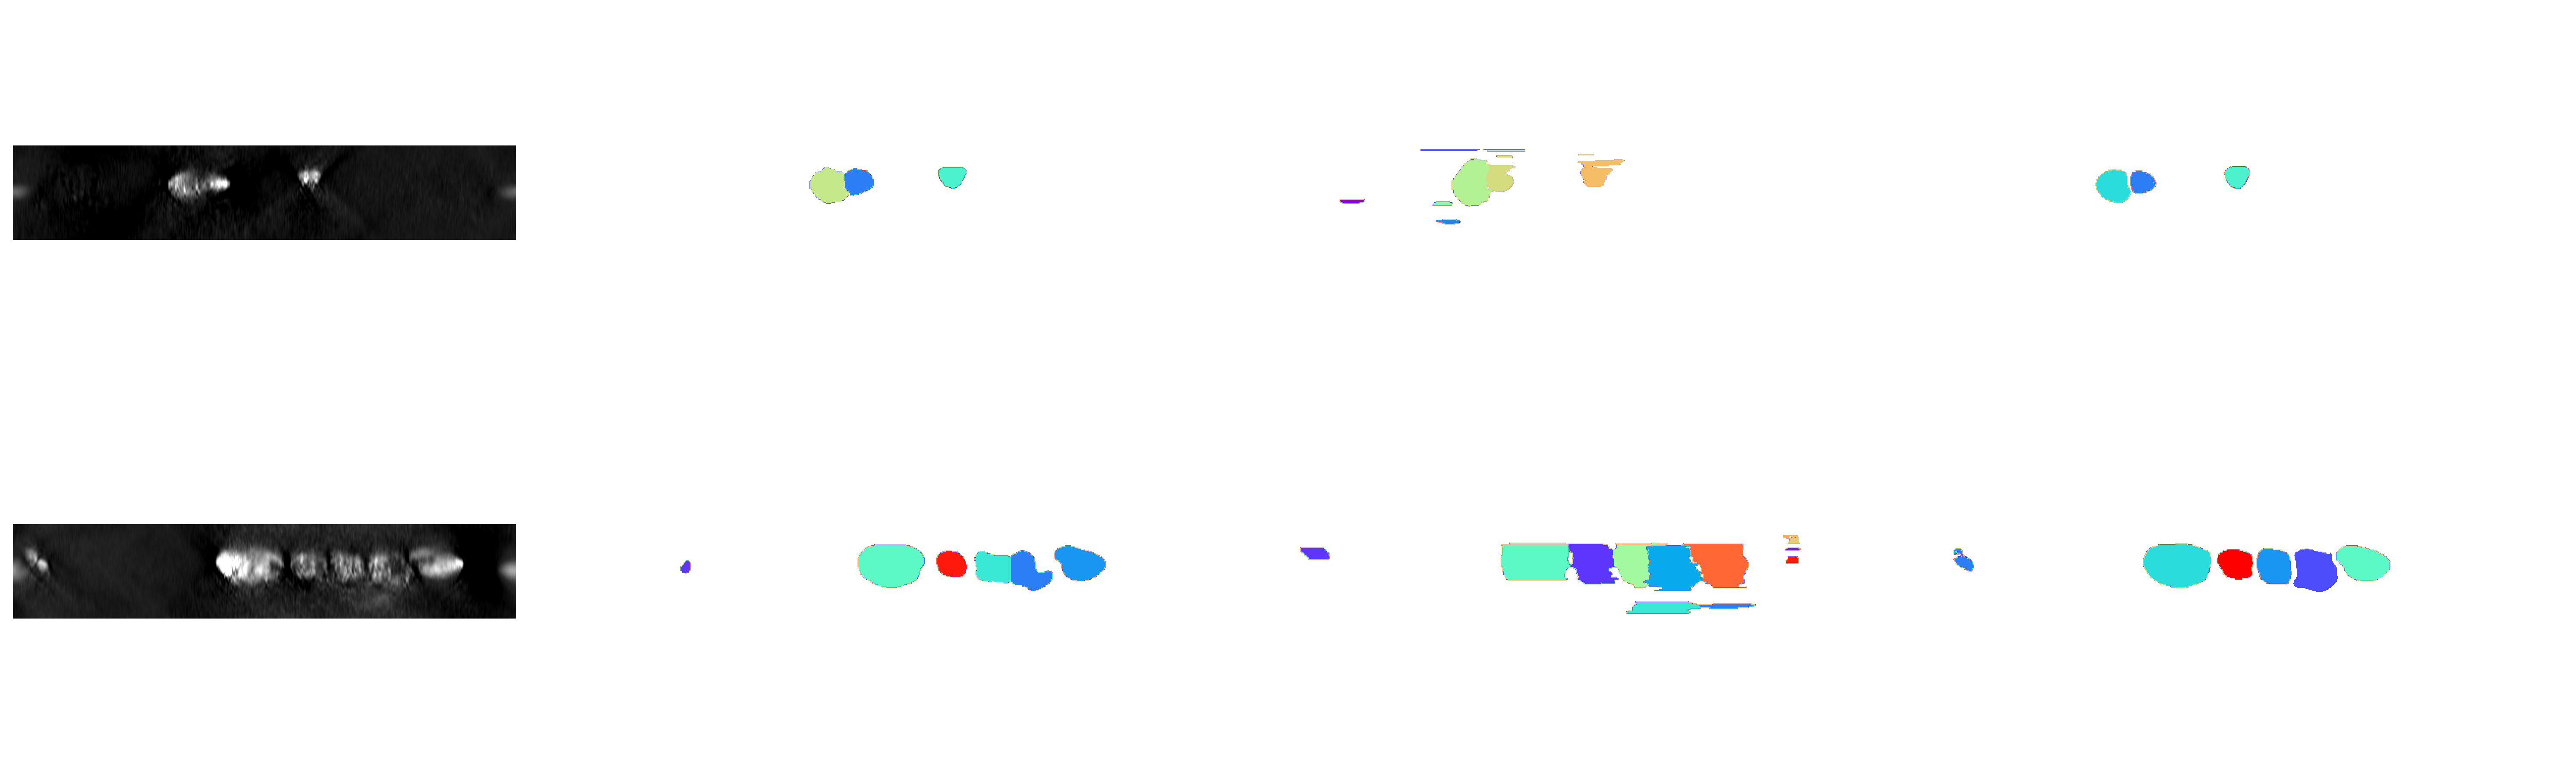

In [129]:
row = 2
col = 8
fig,ax = plt.subplots(row,col,figsize=(20,6), dpi=300,gridspec_kw={'width_ratios': \
                                    [1, width_ratio,1, width_ratio,1, width_ratio,1, width_ratio]})


file_idx = 0
img_raw = tifffile.imread(raw_image_files[file_idx])
img_gt = tifffile.imread(gt_files[file_idx])
# img_gt = measure.label(img_gt,background=0)
img_seg_swincell = tifffile.imread(seg_result_files_swincell[file_idx])
img_seg_cellpose = tifffile.imread(seg_result_files_cellpose[file_idx])

slice_xz1 = 200//downsample_factor
ax[0,0].imshow(img_raw[:,slice_xz1],cmap='gray')
# ax[1,0].set_title('Raw image')

ax[0,2].imshow(img_gt[:,slice_xz1],cmap= get_random_cmap(cell_num))
# ax[1,1].set_title('Ground truth')

ax[0,4].imshow(img_seg_cellpose[:,slice_xz1],cmap= get_random_cmap(cell_num))
# # ax[1,2].set_title('Cellpose')
# ax[2,5].text(textx, texty, 'F1={:0.2f}'.format(cellpose_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)

ax[0,6].imshow(img_seg_swincell[:,slice_xz1],cmap= get_random_cmap(cell_num))
# # ax[1,3].set_title('Swincell')
# ax[2,7].text(textx, texty, 'F1={:0.2f}'.format(swincell_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)

file_idx = 2
img_raw = tifffile.imread(raw_image_files[file_idx])
img_gt = tifffile.imread(gt_files[file_idx])
# img_gt = measure.label(img_gt,background=0)
img_seg_swincell = tifffile.imread(seg_result_files_swincell[file_idx])
img_seg_cellpose = tifffile.imread(seg_result_files_cellpose[file_idx])

slice_xz2 = 200//downsample_factor
ax[1,0].imshow(img_raw[:,slice_xz2],cmap='gray')
# ax[1,0].set_title('Raw image')

ax[1,2].imshow(img_gt[:,slice_xz2],cmap= get_random_cmap(cell_num))
# ax[1,1].set_title('Ground truth')

ax[1,4].imshow(img_seg_cellpose[:,slice_xz2],cmap= get_random_cmap(cell_num))
# # ax[1,2].set_title('Cellpose')
# ax[2,5].text(textx, texty, 'F1={:0.2f}'.format(cellpose_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)

ax[1,6].imshow(img_seg_swincell[:,slice_xz2],cmap= get_random_cmap(cell_num))
# # ax[1,3].set_title('Swincell')
# ax[2,7].text(textx, texty, 'F1={:0.2f}'.format(swincell_f1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)


for i in range(row):
      for j in range(col):
            ax[i,j].axis('off')
plt.tight_layout()

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_difference_map(ground_truth, segmentation):
    # Calculate the difference
    difference = ground_truth != segmentation

    # Extract the coordinates of the difference
    x, y, z = np.where(difference)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot where differences exist
    scatter = ax.scatter(x, y, z, c='r', marker='o')

    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    plt.title('3D Color-Coded Difference Map')

    plt.show()

# Example usage
# ground_truth_mask and segmentation_mask should be 3D numpy arrays of the same shape
# plot_difference_map(img_gt, img_seg_cellpose)


from stardist_matching import matching

swincell_match =matching(img_gt, img_seg_swincell, thresh=0.5,report_matches=True)


In [92]:
print(swincell_match.matched_pairs)
print(dir(swincell_match))


((5, 3), (7, 20), (8, 9), (9, 6), (10, 13), (11, 24), (12, 8), (13, 16), (15, 2), (16, 15), (17, 11), (18, 7), (19, 19), (20, 5), (21, 23), (22, 25), (23, 27), (24, 12), (25, 10), (26, 4), (27, 14), (28, 1), (29, 18), (30, 26), (31, 21), (32, 17), (34, 22))
['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'accuracy', 'count', 'criterion', 'f1', 'fn', 'fp', 'index', 'matched_pairs', 'matched_scores', 'matched_tps', 'mean_matched_score', 'mean_true_score', 'n_pred', 'n_true', 'panoptic_quality', 'precision', 'recall', 'thresh